In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sim_moving import *
from torch.distributions.normal import Normal
import numpy as np
import sys
sys.path.append('/home/hao/Research/probtorch/')
import probtorch

In [2]:
num_tjs = 10000
T = 20
num_digits = 1
step_length = 1.0
frame_size = 64
PATH = '/home/hao/Research/amortized/Moving-MNIST/data/'
mnist_path = '/home/hao/Research/apg_data/mnist/'
file_size = 10000
# simulator = BouncingMNIST(mnist_path=mnist_path, path=PATH, timesteps=T, num_digits=num_digits, step_length=step_length, file_size=file_size)
# simulator.sim_tjs(num_tjs)

Vs = torch.from_numpy(np.load('./data/tjs_v.npy')).float()
Xs = torch.from_numpy(np.load('./data/tjs_x.npy')).float()
##
NUM_HIDDEN = 64
NUM_STEPS = 1000
BATCH_SIZE = 10
SAMPLE_SIZE = 10
CUDA = torch.cuda.is_available()
num_tjs = Vs.shape[0]
num_batches = int(num_tjs /  BATCH_SIZE)
latent_dim = 8
delta_t = 0.2

In [3]:
# class Enc_tj(nn.Module):
#     def __init__(self, input_dim, num_hidden, latent_dim):
#         super(self.__class__, self).__init__()
#         self.enc_w = nn.Sequential(
#                             nn.Linear(input_dim, latent_dim))
#         self.enc_alpha = nn.Sequential(
#                             nn.Linear(input_dim, latent_dim))
#         self.enc_t = nn.Sequential(
#                             nn.Linear(input_dim, latent_dim))
#     def forward(self, x, v):
#         xv = torch.cat((x, v), -1)
#         w = self.enc_w(xv)
#         alpha = self.enc_alpha(xv)
#         t = self.enc_t(xv)
#         x_pred = (w * torch.sin(x * alpha + t)).sum(-1).unsqueeze(-1)
#         min_ind = torch.argmin(alpha, dim=-1).unsqueeze(-1).detach()
        
# #         alpha_min = torch.gather(alpha, 2, min_ind).detach()
# #         w_min = torch.gather(w, 2, min_ind).detach()
# #         t_min = torch.gather(t, 2, min_ind).detach()
#         v_pred = (alpha * w * torch.cos(x * alpha + t)).sum(-1).unsqueeze(-1).detach().sign() * v.abs()
#         return x_pred, v_pred, alpha, w, t

In [4]:
class Enc_tj(nn.Module):
    def __init__(self, input_dim, num_hidden, latent_dim, T, delta_t, CUDA):
        super(self.__class__, self).__init__()
        self.enc_w = nn.Sequential(
                            nn.Linear(input_dim, num_hidden),
                            nn.ReLU(),
                            nn.Linear(num_hidden, latent_dim))
        self.enc_alpha = nn.Sequential(
                            nn.Linear(input_dim, num_hidden),
                            nn.ReLU(),
                            nn.Linear(num_hidden, latent_dim))
        self.enc_t = nn.Sequential(
                            nn.Linear(input_dim, num_hidden),
                            nn.ReLU(),
                            nn.Linear(num_hidden, latent_dim))
        
        
        self.ts =  torch.arange(0, T*delta_t, delta_t).float()
        if CUDA:
            self.ts = self.ts.cuda()
    def forward(self, x):
        B, _ = x.shape
        w = self.enc_w(x)
        alpha = self.enc_alpha(x)
        phase = self.enc_t(x)
        x_pred = (w.unsqueeze(1).repeat(1, T, 1) * torch.sin(torch.bmm(self.ts.repeat(B, 1).unsqueeze(-1), alpha.unsqueeze(1)) + phase.unsqueeze(1).repeat(1, T, 1))).sum(-1)
#         min_ind = torch.argmin(alpha, dim=-1).unsqueeze(-1).detach()
        
#         alpha_min = torch.gather(alpha, 2, min_ind).detach()
#         w_min = torch.gather(w, 2, min_ind).detach()
#         t_min = torch.gather(t, 2, min_ind).detach()
#         v_pred = (alpha * w * torch.cos(x * alpha + t)).sum(-1).unsqueeze(-1).detach().sign() * v.abs()
        return x_pred

In [5]:
enc = Enc_tj(input_dim=T, num_hidden=NUM_HIDDEN, latent_dim=latent_dim, T=T, delta_t=delta_t, CUDA=CUDA)
enc.cuda()
optimizer =  torch.optim.Adam(list(enc.parameters()),lr=1e-4, betas=(0.9, 0.99))

In [7]:
optimizer =  torch.optim.Adam(list(enc.parameters()),lr=1e-4, betas=(0.9, 0.99))
for i in range(NUM_STEPS):
    optimizer.zero_grad()
    indices = torch.randperm(num_tjs)
    LOSS = 0.0
    for b in range(num_batches):
        b_ind = indices[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
        xb = Xs[b_ind].cuda()[:, :, 0] ## B * T
        x_pred = enc(xb)
        loss = ((x_pred - xb)**2).sum(-1).mean()
        loss.backward()
#         v_pred = (torch.sign(xb.grad) * vb.abs()).detach()
        optimizer.step()
        LOSS += loss
        
    %time print('iter=%d, loss=%.6f' % (i, LOSS / num_batches))

iter=0, loss=6.682208
CPU times: user 340 µs, sys: 0 ns, total: 340 µs
Wall time: 326 µs
iter=1, loss=6.675648
CPU times: user 159 µs, sys: 7 µs, total: 166 µs
Wall time: 171 µs
iter=2, loss=6.674612
CPU times: user 183 µs, sys: 8 µs, total: 191 µs
Wall time: 196 µs
iter=3, loss=6.670956
CPU times: user 391 µs, sys: 16 µs, total: 407 µs
Wall time: 412 µs
iter=4, loss=6.671676
CPU times: user 416 µs, sys: 17 µs, total: 433 µs
Wall time: 438 µs
iter=5, loss=6.672876
CPU times: user 155 µs, sys: 6 µs, total: 161 µs
Wall time: 166 µs


KeyboardInterrupt: 

In [ ]:
# optimizer.zero_grad()
# indices = torch.randperm(num_tjs)
# b_ind = indices[0*BATCH_SIZE:(0+1)*BATCH_SIZE]
# xb = Xs[b_ind].cuda()[:, :-1, 0].unsqueeze(-1)
# xb.requires_grad_(True)

# vb = Vs[b_ind].cuda()[:,:-1, 0].unsqueeze(-1)
# x_pred = enc(xb, vb)
# loss = ((x_pred - xb)**2).sum(-1).mean()
# loss.backward()

In [ ]:
s = 4
optimizer.zero_grad()
xb = Xs[s:(s+1)].cuda()[:,:, 0]
# xb.requires_grad_(True)
x_pred = enc(xb)
# x_pred.backward()
# v_pred = (torch.sign(xb.grad) * vb.abs()).detach()
# x_pred = x_pred.squeeze(0)

In [8]:
P = 20
XP = []
VP = []
xp = x_pred[0, 0, :].unsqueeze(0).unsqueeze(0)
# vp = v_pred[0, -1, :].unsqueeze(0).unsqueeze(0)
vp = vb[0, 0, :].unsqueeze(0).unsqueeze(0)
VP.append(vp.unsqueeze(0))
XP.append(xp.unsqueeze(0))

for p in range(P):
    xp, vp, _, _, _ = enc(xp,vp)
    XP.append(xp.unsqueeze(0))
    VP.append(vp.unsqueeze(0))
VP = torch.cat(VP, 0).squeeze(1)
XP = torch.cat(XP, 0).squeeze(1)

IndexError: too many indices for tensor of dimension 2

In [ ]:
xb.shape

In [ ]:
# space = torch.linspace(0, 20, 200)
# wave = (w.cpu()[0, 0, :] * torch.sin(space.unsqueeze(-1).repeat(1, 8) * alpha.cpu()[0, 0, :] + t.cpu()[0, 0, :])).sum(-1).unsqueeze(-1)
# grad = (alpha.cpu()[0, 0, :] * w.cpu()[0, 0, :] * torch.cos(space.unsqueeze(-1).repeat(1, 8) * alpha.cpu()[0, 0, :] + t.cpu()[0, 0, :])).sum(-1).unsqueeze(-1).detach().sign() * vb[0, 0, 0].cpu().abs()

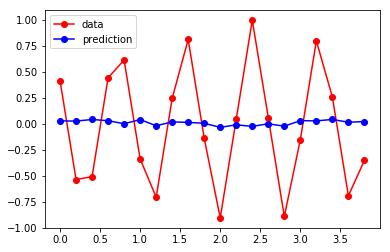

In [10]:
s = 9
optimizer.zero_grad()
xb = Xs[s:(s+1)].cuda()[:,:, 0]
# xb.requires_grad_(True)
x_pred = enc(xb)

x_plt = np.arange(0, 0.2*20, 0.2)
plt.plot(x_plt, xb[0].cpu().data.numpy(), c='r', marker='o', label='data')
plt.plot(x_plt, x_pred[0].cpu().data.numpy(), c='b', marker='o', label='prediction')
plt.legend()
# plt.plot(x_plt, XP[:, 0, 0].cpu().data.numpy(), c='m')
# plt.plot(space.data.numpy(), wave.data.numpy())
# plt.plot(space.data.numpy(), grad.data.numpy(), marker='o')

In [ ]:
plt.scatter(xb[0, 1:, 0].cpu().data.numpy(), xb[0, 1:, 1].cpu().data.numpy(), c='r')
# plt.scatter(x_pred[:, 0].cpu().data.numpy(), x_pred[:, 1].cpu().data.numpy(), c='b')
# plt.scatter(XP[:, 0].cpu().data.numpy(), XP[:, 1].cpu().data.numpy(), c='m')

In [ ]:
list(enc.parameters())

In [ ]:
x_plt.shape

In [ ]:
xb.shape